# Tuning the hyperparameters of a support vector machine

The main goal of this presentation is to utilize the techniques and best practices we learned in the workshop, present these in an organized manner, tune the hyperparameters of the SVM to get the best scores, and graph the relationship of these hyperparameters to performance.

The goal is NOT to get insight from the data.

## About the data

Adult Census Income Binary Classification dataset

A subset of the 1994 Census database, using working adults over the age of 16 with an adjusted income index of > 100.

<b>Usage:</b> Classify people using demographics to predict whether a person earns over 50K a year.

Related Research: Kohavi, R., Becker, B., (1996). UCI Machine Learning Repository http://archive.ics.uci.edu/ml. Irvine, CA: University of California, School of Information and Computer Science

# Step 1: Importing our initial libraries

In [150]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/home/beato/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test', 'colors', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Step 2: Cleaning the data

## Dropped na, Used OneHot

In [151]:
#from sklearn.preprocessing import OneHotEncoder

def read_and_clean(path, exc_col=exc_col):
    """Load dataset from path and pre-process. 
    
    Strip leading and trailing whitespace.
    
    returns a DataFrame
    """
    data = pd.read_csv(path, delimiter=' *, *', engine='python')
    data.replace({'?': 0}, inplace=True)
    data.dropna(inplace=True)
    cols = data.keys()
    
    dummied_data = pd.get_dummies(data.drop('income', 1))
    dummied_data['income'] = data['income']
    dummied_data.replace({
        '<=50K': 0,
        '>50K': 1
    }, inplace=True)
    
    return dummied_data

data = read_and_clean('Adult Census Income Binary Classification dataset.csv')
data.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_0,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Step 3: Feature Scaling

## Mean normalization

In [152]:
def do_feature_scaling(col, data):
    """Applies mean normalization to a column.
    
    Modifies data in place.
    """
    _std = np.std(data[col])
    _mean = np.mean(data[col])
    
    data[col] = (data[col] - _mean) / _std

for s in ['age', 'fnlwgt', 'education-num', 'capital-gain', 
          'capital-loss', 'hours-per-week']:
    do_feature_scaling(s, data)


## Applying PCA

### n_components was tested by one by one

In [153]:
from sklearn.decomposition import PCA

SPLIT = 7500

pca = PCA(n_components=20)
pca_out = pca.fit_transform(data.drop('income', 1))
data2 = pd.DataFrame(pca_out)
data2 = data2.set_index(data.index)
data2['income'] = data['income']

data2 = (data2[data2['income'] == 1].sample(SPLIT, random_state=0)
        .append(data2[data2['income']==0].sample(SPLIT, random_state=0)))

# Step 4: Training the model w/ different hyper parameters

## Using GridSearch and K-fold Cross Validation (k=5)
## Train/test split = Pareto Principle 80/20

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

SEED = 0
RESULTS = {}
c = np.arange(100, 1001, 100)
g = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

def run_svm(label, data, random_state):
    tuned_parameters = [
        {'kernel': ['poly'], 'degree': [2, 3, 4], 'gamma': g, 'C': c},
        {'kernel': ['sigmoid'], 'gamma': g, 'C': c},  
        {'kernel': ['rbf'], 'gamma': g, 'C': c},
        {'kernel': ['linear'], 'C': [1, 100]}, # takes SUPER long
                       ]
    
    X = data.drop(label, 1)
    y = data[label]
    (X_train, X_test, 
     y_train, y_test) = train_test_split(X, y, random_state=random_state,
                                         test_size=.2, stratify=y)
    
    clf = GridSearchCV(svm.SVC(random_state=random_state), tuned_parameters, cv=5)
    clf.fit(X_train, y_train)
    print(clf.best_params_)

    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))

    return clf

clf = run_svm('income', data2, SEED)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
             precision    recall  f1-score   support

          0       0.86      0.76      0.81      3750
          1       0.79      0.88      0.83      3750

avg / total       0.82      0.82      0.82      7500



# Step 5: Teamwork!
## Working together with Insync, Microsoft Azure and std library's pickle!

In [232]:
import pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

loaded_clf = load_obj('data')


## We ran a total of 252 parameters pairs!
## With k=5 I guess that's 252 * 5 = 1260?

In [233]:
prms = loaded_clf.cv_results_['params']
print(len(prms))
prms

252


({'C': 100, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'},
 {'C': 100, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'},
 {'C': 100, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'},
 {'C': 100, 'degree': 2, 'gamma': 0.0001, 'kernel': 'poly'},
 {'C': 100, 'degree': 2, 'gamma': 1e-05, 'kernel': 'poly'},
 {'C': 100, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'},
 {'C': 100, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'},
 {'C': 100, 'degree': 3, 'gamma': 0.001, 'kernel': 'poly'},
 {'C': 100, 'degree': 3, 'gamma': 0.0001, 'kernel': 'poly'},
 {'C': 100, 'degree': 3, 'gamma': 1e-05, 'kernel': 'poly'},
 {'C': 100, 'degree': 4, 'gamma': 0.1, 'kernel': 'poly'},
 {'C': 100, 'degree': 4, 'gamma': 0.01, 'kernel': 'poly'},
 {'C': 100, 'degree': 4, 'gamma': 0.001, 'kernel': 'poly'},
 {'C': 100, 'degree': 4, 'gamma': 0.0001, 'kernel': 'poly'},
 {'C': 100, 'degree': 4, 'gamma': 1e-05, 'kernel': 'poly'},
 {'C': 200, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'},
 {'C': 200, 'degree': 2, 'gamma': 0.01, 'kernel'

# Step 6: Making sense of the output

In [216]:
X = data2.drop('income', 1)
y = data2['income']
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y, random_state=0,
                                         test_size=.2, stratify=y)

res = pd.DataFrame(loaded_clf.cv_results_)
y_pred = loaded_clf.predict(X_test)

print('---BEST PARAMETERS---')
print(loaded_clf.best_params_)
print('---CLASSIFICATION REPORT---')
print(classification_report(y_test, y_pred))

---BEST PARAMETERS---
{'kernel': 'rbf', 'C': 900, 'gamma': 0.01}
---CLASSIFICATION REPORT---
             precision    recall  f1-score   support

          0       0.87      0.76      0.81      1500
          1       0.79      0.88      0.83      1500

avg / total       0.83      0.82      0.82      3000



# Best effort (0.82 f1-score)
## RBF, C=900, gamma=0.01

class | precision | recall | f1-score | support
-- | -- | -- | -- | --
0 | 0.87 | 0.76 | 0.81 | 1500
1 | 0.79 | 0.88 | 0.83 | 1500
avg / total | 0.83 | 0.82 | 0.82 | 3000

In [217]:
from sklearn import metrics

def prep_fig(title, height=5):
    plt.clf()
    plt.figure(figsize=(15, height))
    plt.suptitle(title, fontsize=30)
    plt.legend()

# Looking at dem curves!
## Checking our classifier with ROC, AUC, and Precision Recall

ROC - Receiver Operating Characteristics

Specificity (x) is a performance measure of the whole negative part of a dataset, whereas sensitivity (y) is a performance measure of the whole positive part.

AUC - area under ROC

Precision Recall

* recall (x) - performance of whole positive part
* precision (y) - performance measure of positive predictions




/home/beato/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


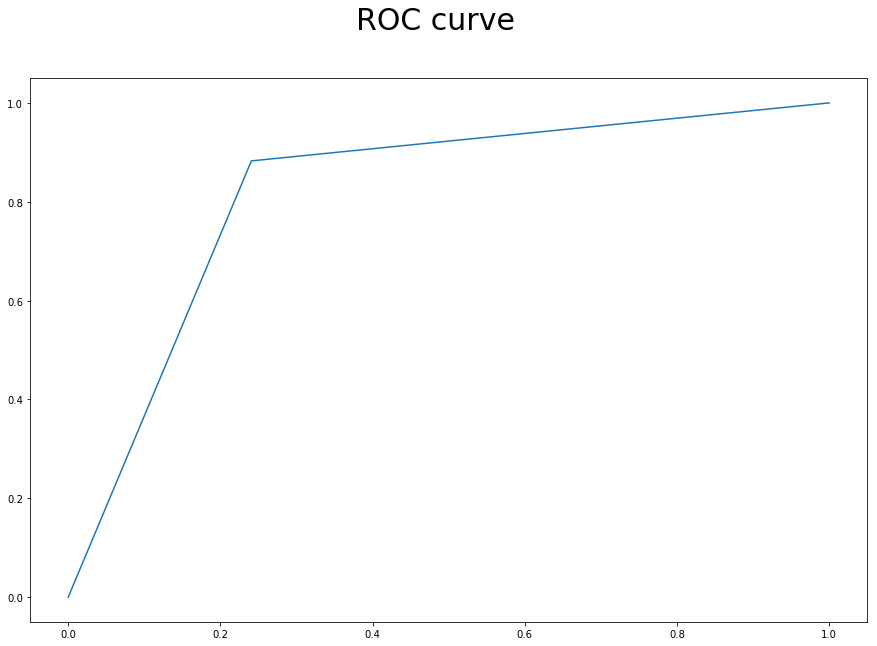

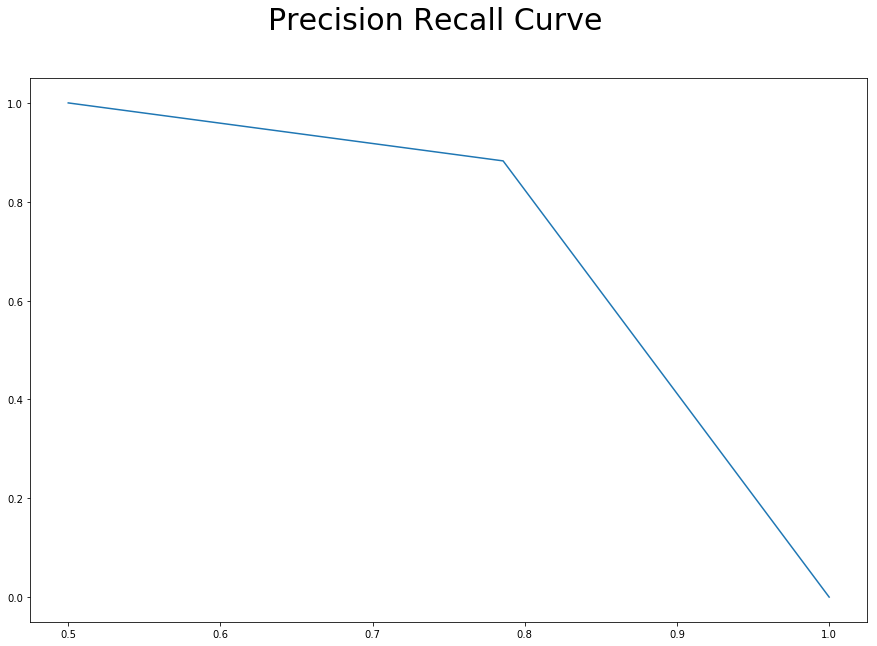

ROC AUC: 0.821


In [219]:
pcc = metrics.precision_recall_curve(y_test, y_pred)
roc = metrics.roc_curve(y_test, y_pred)

prep_fig('ROC curve', height=10)
plt.plot(roc[0], roc[1])
plt.show()

prep_fig('Precision Recall Curve', height=10)
plt.plot(pcc[0], pcc[1])
plt.show()

print('ROC AUC:', metrics.roc_auc_score(y_test, y_pred))

# Checking kernel performance

/home/beato/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


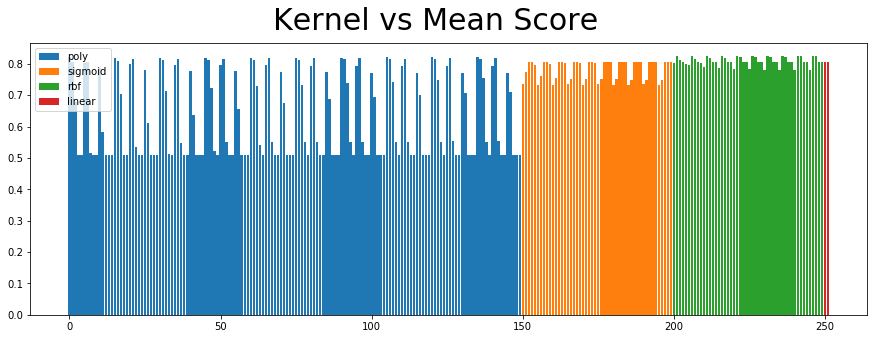

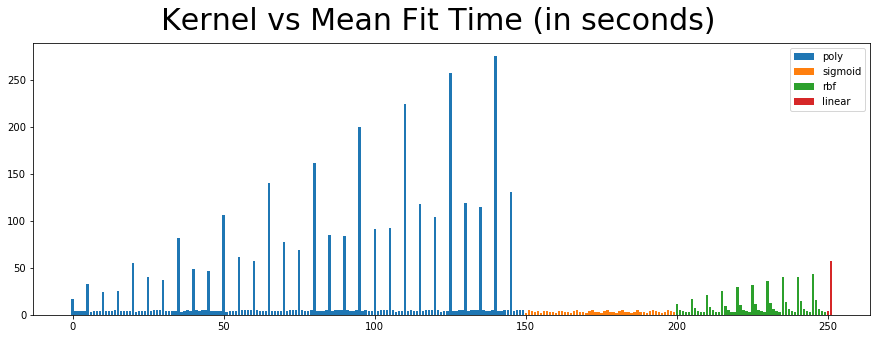

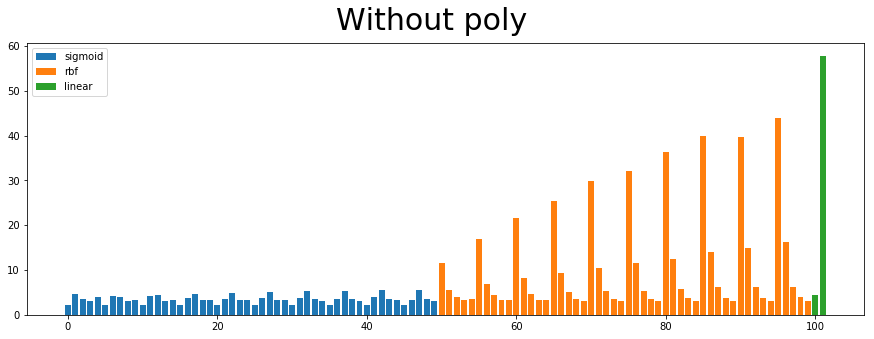

In [238]:
def get_bar(title, target, to_measure, include=None):
    prep_fig(title)
    last = 0

    for i, k in enumerate(res[target].unique()):
        if include and k in include:
            heights = res[res[target] == k][to_measure]
            plt.bar(list(range(last, last + len(heights))), heights, label=k)
            last += len(heights)  
    plt.legend()
    plt.show()
    
get_bar('Kernel vs Mean Score', 'param_kernel', 'mean_test_score', include=['sigmoid', 'rbf', 'linear', 'poly'])
get_bar('Kernel vs Mean Fit Time (in seconds)', 'param_kernel', 'mean_fit_time', include=['sigmoid', 'rbf', 'linear', 'poly'])
get_bar('Without poly', 'param_kernel', 'mean_fit_time', include=['sigmoid', 'rbf', 'linear'])

# Effect of hyperparameters on kernels

## If testing C, hold gamma at 1e-3
## If testing gamma, hold C at 900

Caveats:

* too high a C could result in overfitting, however this was cross validated so we don't think this is the case.

In [289]:
hold_gamma = (res['param_gamma'] == 1e-3)
hold_c = (res['param_C'] == 900)

def graph_kernel_factor_vs(title, f1, f2, kernel, hold=None, plt_type='linear'):
    prep_fig(title)
    test = res[(res['param_kernel'] == kernel) & hold]
    _plt = None
    if plt_type == 'linear':
        _plt = plt.plot(test[f1], test[f2], label=title,)
    elif plt_type == 'scatter':
        _plt = plt.scatter(test[f1], test[f2], label=title)
    plt.show()

# RBF

/home/beato/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


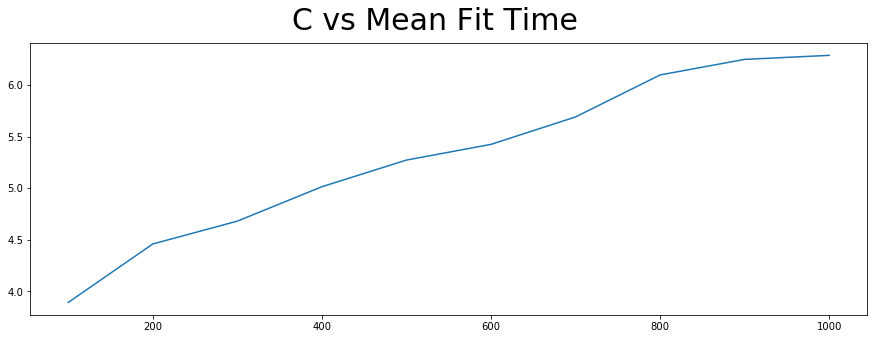

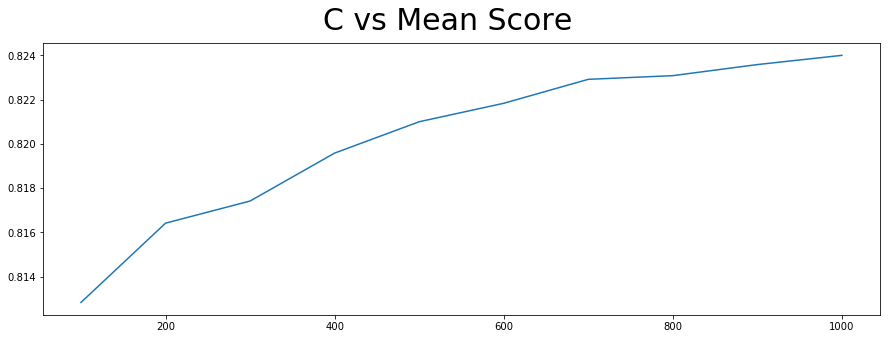

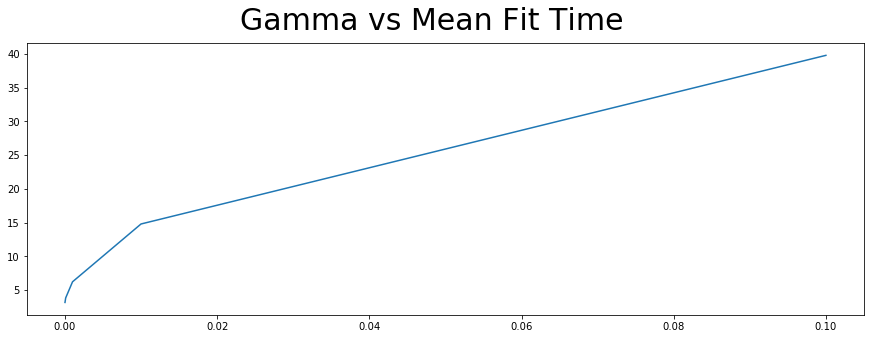

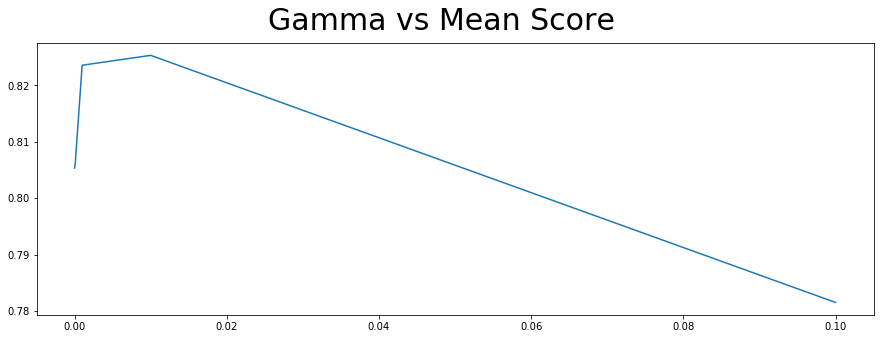

In [290]:
graph_kernel_factor_vs('C vs Mean Fit Time', 'param_C', 'mean_fit_time', 'rbf', hold=hold_gamma)
graph_kernel_factor_vs('C vs Mean Score', 'param_C', 'mean_test_score', 'rbf', hold=hold_gamma)

graph_kernel_factor_vs('Gamma vs Mean Fit Time', 'param_gamma', 'mean_fit_time', 'rbf', hold=hold_c)
graph_kernel_factor_vs('Gamma vs Mean Score', 'param_gamma', 'mean_test_score', 'rbf', hold=hold_c)

# Poly

/home/beato/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


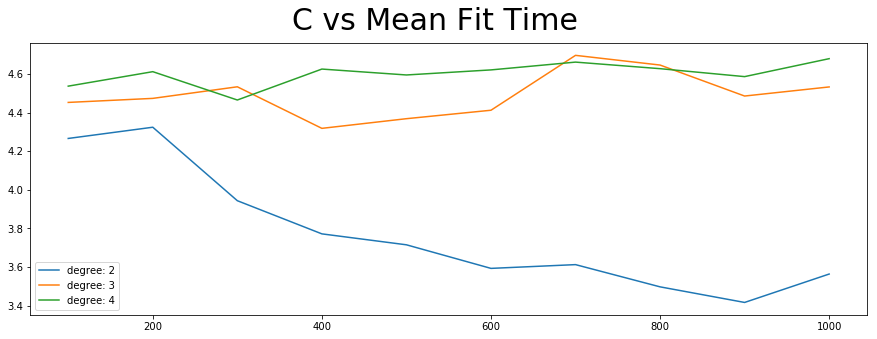

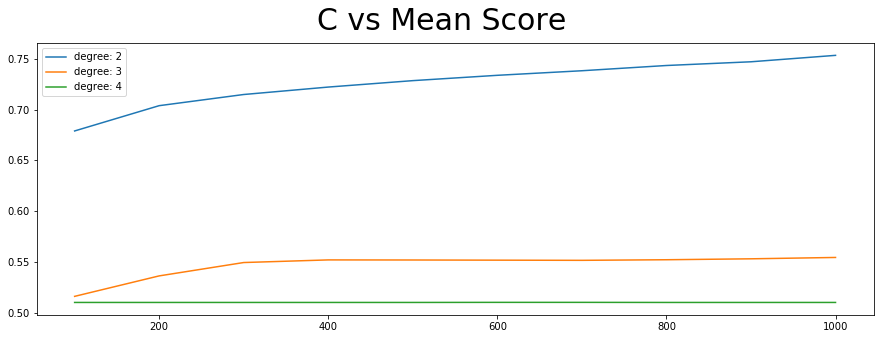

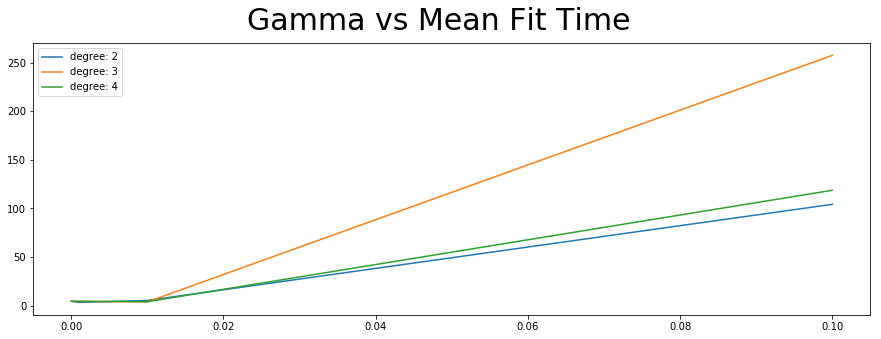

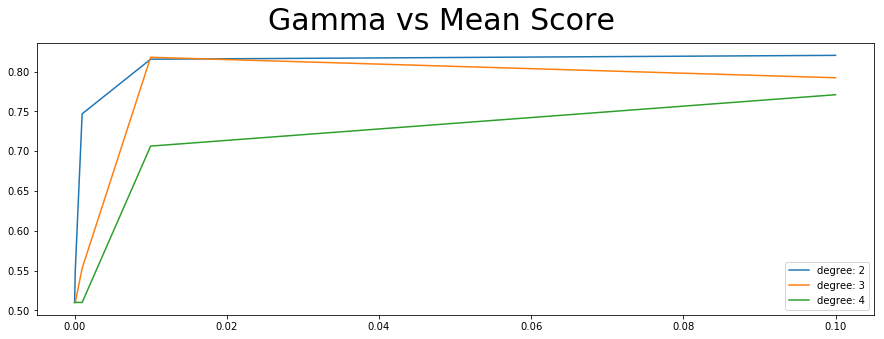

In [294]:
def graph_kernel_factor_poly(title, f1, f2, kernel, hold=None):
    prep_fig(title)
    for x in range(2,5):        
        test = res[(res['param_kernel'] == kernel) & hold & (res['param_degree'] == x)]
        plt.plot(test[f1], test[f2], label='degree: ' + str(x))
    plt.legend()
    plt.show()

graph_kernel_factor_poly('C vs Mean Fit Time', 'param_C', 'mean_fit_time', 'poly', hold=hold_gamma)
graph_kernel_factor_poly('C vs Mean Score', 'param_C', 'mean_test_score', 'poly', hold=hold_gamma)

graph_kernel_factor_poly('Gamma vs Mean Fit Time', 'param_gamma', 'mean_fit_time', 'poly', hold=hold_c)
graph_kernel_factor_poly('Gamma vs Mean Score', 'param_gamma', 'mean_test_score', 'poly', hold=hold_c)

/home/beato/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


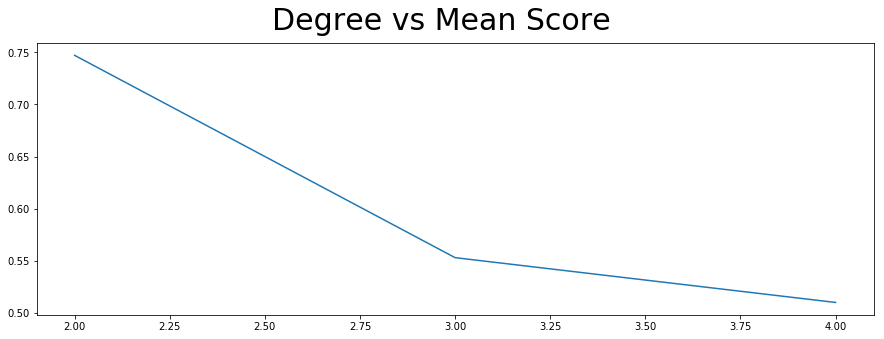

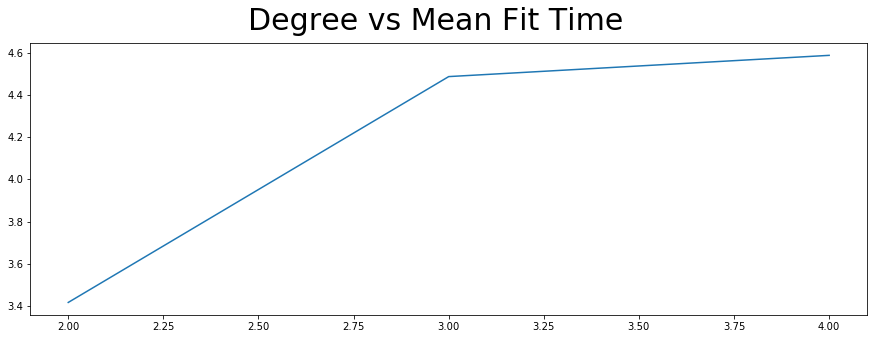

In [295]:
graph_kernel_factor_vs('Degree vs Mean Score', 'param_degree', 'mean_test_score', 'poly', hold=(hold_gamma & hold_c))
graph_kernel_factor_vs('Degree vs Mean Fit Time', 'param_degree', 'mean_fit_time', 'poly', hold=(hold_gamma & hold_c))

# Observations

 * convergence was super slow even with just 500 samples 
 * We used PCA and feature scaling and it really sped up. Was able to run GridSearch on 10k rows and not wait so long.
 * PCA: n_components affects the final score
 * categorical data should not be represented by numbers, should be transformed into columns with 0 or 1. We used OneHot for this.
 * linear took super long the higher C is! Maybe exponential?
 * highest f1 possible we found is .84, but our class 1 score sucked. We halved the data because of this based on label. Once we did this, fscore went down to .82 but now it's quite balanced!

# Thanks for listening guys!